<font size="+3"><strong>Predicting Price with Size, Location, and Neighborhood</strong></font>

In [39]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

In [40]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop features with high NaN values
    df.drop(columns=["floor","expenses"], inplace=True)

    # Drop low and high-cardinality categorical variables
    df.drop(columns=["operation","property_type","currency","properati_url"], inplace=True)

    # Drop leaky columns
    df.drop(columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2',],
        inplace=True)

    # Drop columns with multicollinearlity
    df.drop(columns=["surface_total_in_m2","rooms"],inplace=True)


    return df

Use [`glob`](https://docs.python.org/3/library/glob.html#glob.glob) to create a list that contains the filenames for all the Buenos Aires real estate XLSX files in the `data` directory. Assign this list to the variable name `files`.

In [41]:
files = glob("buenos-aires-real-estate-*.xlsx")
files

['buenos-aires-real-estate-1.xlsx',
 'buenos-aires-real-estate-2.xlsx',
 'buenos-aires-real-estate-3.xlsx',
 'buenos-aires-real-estate-4.xlsx',
 'buenos-aires-real-estate-5.xlsx']

In [42]:
# Check the work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

Use the `wrangle` function in a list comprehension to create a list named `frames`. The list should contain the cleaned DataFrames for the filenames collected in `files`.

In [43]:
frames = [wrangle(file) for file in files]

Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate it items in `frames` into a single DataFrame `df`. Set the `ignore_index` argument to `True`.

In [44]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


## Explore

Modify the `wrangle` function to drop any columns that are more than half `NaN` values. Rerun all the cells above.


The next thing is to look out for categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to the model. At the other extreme, columns where nearly every row has its own category won't help the model in identifying useful trends in the data.

Calculate the number of unique values for each non-numeric feature in `df`.

In [45]:
df.select_dtypes("object").head()

,neighborhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constitución
4,Once


Columns like `"operation"` have only one value in them, while every row in `"properati_url"` has a unique value. These are clear examples of high- and low-cardinality features that shouldn't be included in the model.

Modify the `wrangle` function to drop any features that would constitute leakage.

In [46]:
sorted(df.columns)

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

Finally, the last issue is to keep an eye out for **multicollinearity**, that is, features in the feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap.

Plot a correlation heatmap of the remaining numerical features in `df`. Since `"price_aprox_usd"` will be the target, no need to include it in the heatmap.

<AxesSubplot:>

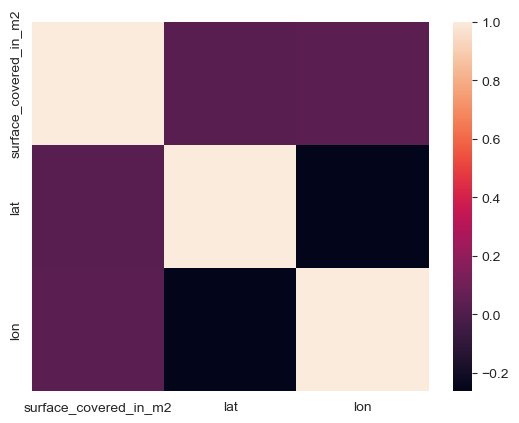

In [47]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

Modify the `wrangle` function to remove columns so that there are no strongly correlated features in the feature matrix.

## Split Data

Create the feature matrix `X_train` and target vector `y_train`. Target is `"price_aprox_usd"`. The features should be all the columns that remain in the DataFrame cleaned above.

In [48]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]

X_train = df[features]
y_train = df[target]

In [50]:
# Check the work
assert X_train.shape == (6582, 4), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model

## Baseline

Calculate the baseline mean absolute error for the model.

In [51]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274134


## Iterate

Create a pipeline named `model` that contains a `OneHotEncoder`, `SimpleImputer`, and `Ridge` predictor.

In [52]:
model = make_pipeline(OneHotEncoder(use_cat_names=True), SimpleImputer(), Ridge())
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

Calculate the training mean absolute error for your predictions as compared to the true targets in `y_train`.

In [53]:
y_pred_train = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_train))

Training MAE: 24207.107190330335


Import the test data `buenos-aires-test-features.xlsx` into a DataFrame and generate a list of predictions using the model.

In [57]:
X_test = pd.read_excel("buenos-aires-test-features1.xlsx")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

# Communicate Results

I've relied on equations and visualizations for communication about the model. In many data science projects, however, communication means giving stakeholders tools they can use to **deploy** a model — in other words, use it in action. There are two ways I want to use to deploy this model.

Create a function `make_prediction` that takes four arguments (`area`, `lat`, `lon`, and `neighborhood`) and returns the model's prediction for an apartment price.

In [60]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [61]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Create one using [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html).

Add the `make_prediction` to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes.

- Create an interact function in Jupyter Widgets.

In [62]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…